## Install the package dependencies before running this notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lstm_encoder_decoder2

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [4]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "../../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "val", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    outputs = None
    
    if split == "train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    elif split == 'test':
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
    else:
        print('\"split\" should be train, val, or test.')
        inputs = None

    return inputs, outputs

class ArgoverseDataset(Dataset):
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.split = split
        self.input_positions, self.output_positions = get_city_trajectories(city=city, split=split, normalized=False)
        
        self.input_positions = torch.Tensor(self.input_positions)
        num_inputs, input_seq_len = self.input_positions.shape[:2]
        self.center_input = (
            np.repeat(self.input_positions[:, 0, :], input_seq_len, axis=0)
            .reshape(num_inputs, input_seq_len, 2)
        )
        self.center = (
            np.repeat(self.input_positions[:, 0, :], 60, axis=0)
            .reshape(num_inputs, 120)
        )
        
        self.input_positions_centered = torch.Tensor(self.input_positions - self.center_input)
        self.input_velocities = torch.Tensor(np.diff(self.input_positions, axis=1))
        
        self.nn1_inputs = self.input_positions_centered
        self.nn2_inputs = self.input_velocities
        
        if split != 'test': 
            self.output_positions = torch.Tensor(self.output_positions)
            num_outputs, output_seq_len = self.output_positions.shape[:2]
            center_output = (
                np.repeat(self.input_positions[:, 0, :], output_seq_len, axis=0)
                .reshape(num_outputs, output_seq_len, 2)
            )
            self.output_positions_centered = torch.Tensor(self.output_positions - center_output)
            self.output_velocities = torch.Tensor(np.diff(self.output_positions, axis=1))
                    
            self.nn1_outputs = self.output_positions_centered[:, 0, :].unsqueeze(1)
            self.nn2_outputs = self.output_velocities

    def __len__(self):
        return len(self.nn1_inputs)

    def __getitem__(self, idx):
        if self.split != 'test':
            data = (
                self.nn1_inputs[idx], 
                self.nn1_outputs[idx], 
                self.nn2_inputs[idx], 
                self.nn2_outputs[idx],
                self.input_positions[idx],
                self.output_positions[idx],
                self.input_positions_centered[idx],
                self.output_positions_centered[idx]
            )
        else:
            data = data = (
                self.nn1_inputs[idx], 
                self.nn2_inputs[idx], 
                self.center[idx]
            )
        return data

In [5]:
train_dataset = ArgoverseDataset('austin', 'train')
val_dataset = ArgoverseDataset('austin', 'train')
test_dataset = ArgoverseDataset('austin', 'test')

In [6]:
X_train_nn1 = train_dataset.nn1_inputs
print('X_train_nn1:', X_train_nn1.shape)
y_train_nn1 = train_dataset.nn1_outputs
print('y_train_nn1:', y_train_nn1.shape)
X_train_nn2 = train_dataset.nn2_inputs
print('X_train_nn2:', X_train_nn2.shape)
y_train_nn2 = train_dataset.nn2_outputs
print('y_train_nn2:', y_train_nn2.shape)
X_train = train_dataset.input_positions
print('X_train:', X_train.shape)
y_train = train_dataset.output_positions
print('y_train:', y_train.shape)

X_train_nn1: torch.Size([34432, 50, 2])
y_train_nn1: torch.Size([34432, 1, 2])
X_train_nn2: torch.Size([34432, 49, 2])
y_train_nn2: torch.Size([34432, 59, 2])
X_train: torch.Size([34432, 50, 2])
y_train: torch.Size([34432, 60, 2])


## Train NN1

In [45]:
nn1 = lstm_encoder_decoder2.lstm_seq2seq(
    input_size = 2, 
    input_len = 50,
    hidden_size = 16,
    output_size = 2,
    num_layers = 1,
    dropout = 0.3
)

### Keep track of number of times that `scheduler` decreases learning rate, and multiply `threshold` and `learning_rate` by $0.1$ by that number of times.

Training on Austin
Epoch 0 train loss, validation loss, time: 44.18556, 28.23833, 4.93261
Epoch 3 train loss, validation loss, time: 5.06243, 4.96641, 4.51924
Epoch 6 train loss, validation loss, time: 1.37798, 2.50491, 4.78983
Epoch 9 train loss, validation loss, time: 0.71197, 1.91653, 4.40088
Epoch 12 train loss, validation loss, time: 0.45217, 1.47672, 4.41925
Epoch 15 train loss, validation loss, time: 0.34599, 1.46722, 4.40181
Epoch 18 train loss, validation loss, time: 0.29399, 1.38274, 4.42458
Epoch 21 train loss, validation loss, time: 0.26094, 1.14020, 4.39667
Epoch 24 train loss, validation loss, time: 0.22821, 1.12254, 4.39086
Epoch 27 train loss, validation loss, time: 0.23122, 0.99223, 4.53166


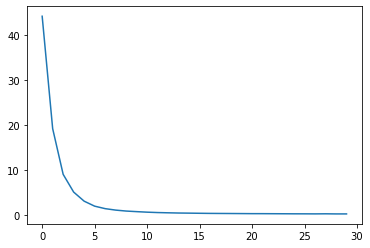

In [49]:
print('Training on Austin')
train_dataset = ArgoverseDataset(city='austin', split='train')
val_dataset = ArgoverseDataset(city='austin', split='val')
X_train_nn1 = train_dataset.nn1_inputs
y_train_nn1 = train_dataset.nn1_outputs
X_val_nn1 = val_dataset.nn1_inputs
y_val_nn1 = val_dataset.nn1_outputs
loss1 = nn1.train_model(
    X_train_nn1, 
    y_train_nn1, 
    X_val_nn1,
    y_val_nn1,
    n_epochs = 30, 
    target_len = 1, 
    batch_size = 32, 
    patience = 10,
    threshold = 1e-3,
    training_prediction = 'recursive', 
    learning_rate = 1e-3
)
plt.plot(loss1)

Training on Miami
Epoch 0 train loss, validation loss, time: 179.02432, 0.88285, 13.35955
Epoch 3 train loss, validation loss, time: 111.34392, 0.82648, 12.69744
Epoch 6 train loss, validation loss, time: 95.45717, 0.74283, 13.56006
Epoch 9 train loss, validation loss, time: 94.75955, 0.70263, 12.92240
Epoch 12 train loss, validation loss, time: 93.99613, 0.68801, 13.27664
Epoch 15 train loss, validation loss, time: 86.42304, 0.66411, 15.85282
Epoch 18 train loss, validation loss, time: 75.86799, 0.63188, 13.23280
Epoch 21 train loss, validation loss, time: 61.83117, 0.59810, 13.27137
Epoch 24 train loss, validation loss, time: 47.03385, 0.66157, 19.31397
Epoch 27 train loss, validation loss, time: 42.93984, 0.63315, 13.70387


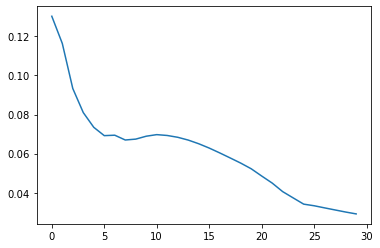

In [192]:
print('Training on Miami')
train_dataset = ArgoverseDataset(city='miami', split='train')
val_dataset = ArgoverseDataset(city='miami', split='val')
X_train_nn1 = train_dataset.nn1_inputs
y_train_nn1 = train_dataset.nn1_outputs
X_val_nn1 = val_dataset.nn1_inputs
y_val_nn1 = val_dataset.nn1_outputs
loss1 = nn1.train_model(
    X_train_nn1, 
    y_train_nn1, 
    X_val_nn1,
    y_val_nn1,
    n_epochs = 30, 
    target_len = 1, 
    batch_size = 32, 
    patience = 8,
    threshold = 1e-4,
    training_prediction = 'recursive', 
    learning_rate = 1e-4
)
plt.plot(loss1)

Training on Pittsburgh
Epoch 0 train loss, validation loss, time: 0.43115, 0.84263, 9.86024
Epoch 3 train loss, validation loss, time: 0.17016, 0.63363, 9.40656
Epoch 6 train loss, validation loss, time: 0.11335, 0.51353, 10.24342
Epoch 9 train loss, validation loss, time: 0.08315, 0.50303, 9.97556
Epoch 12 train loss, validation loss, time: 0.06540, 0.43314, 10.30843
Epoch 15 train loss, validation loss, time: 0.05400, 0.38381, 14.29748
Epoch 18 train loss, validation loss, time: 0.04757, 0.35453, 11.38427
Epoch 21 train loss, validation loss, time: 0.04060, 0.31302, 11.81986
Epoch 24 train loss, validation loss, time: 0.03416, 0.29718, 12.23002
Epoch 27 train loss, validation loss, time: 0.02831, 0.28591, 12.26419


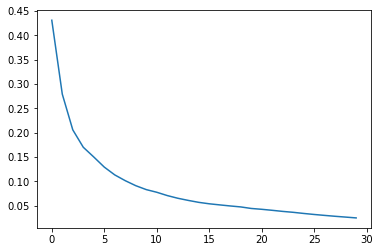

In [194]:
print('Training on Pittsburgh')
train_dataset = ArgoverseDataset(city='pittsburgh', split='train')
val_dataset = ArgoverseDataset(city='pittsburgh', split='val')
X_train_nn1 = train_dataset.nn1_inputs
y_train_nn1 = train_dataset.nn1_outputs
X_val_nn1 = val_dataset.nn1_inputs
y_val_nn1 = val_dataset.nn1_outputs
loss1 = nn1.train_model(
    X_train_nn1, 
    y_train_nn1, 
    X_val_nn1,
    y_val_nn1,
    n_epochs = 30, 
    target_len = 1, 
    batch_size = 32, 
    patience = 8,
    threshold = 1e-4,
    training_prediction = 'recursive', 
    learning_rate = 1e-4
)
plt.plot(loss1)

Training on Miami
Epoch 0 train loss, validation loss, time: 0.02111, 0.16370, 17.82272
Epoch 3 train loss, validation loss, time: 0.00674, 0.13820, 16.02021
Epoch 6 train loss, validation loss, time: 0.00591, 0.14106, 13.09620
Epoch 9 train loss, validation loss, time: 0.00545, 0.13718, 13.32007
Epoch 12 train loss, validation loss, time: 0.00515, 0.14188, 14.65663
Epoch 15 train loss, validation loss, time: 0.00492, 0.14236, 14.78997
Epoch 00017: reducing learning rate of group 0 to 1.0000e-05.
Epoch 18 train loss, validation loss, time: 0.00380, 0.13822, 19.49403
Epoch 21 train loss, validation loss, time: 0.00350, 0.14038, 15.51474
Epoch 24 train loss, validation loss, time: 0.00337, 0.14240, 17.34413
Epoch 00026: reducing learning rate of group 0 to 1.0000e-06.
Epoch 27 train loss, validation loss, time: 0.00756, 0.13528, 15.96336


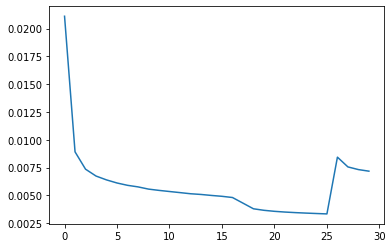

In [195]:
print('Training on Miami')
train_dataset = ArgoverseDataset(city='miami', split='train')
val_dataset = ArgoverseDataset(city='miami', split='val')
X_train_nn1 = train_dataset.nn1_inputs
y_train_nn1 = train_dataset.nn1_outputs
X_val_nn1 = val_dataset.nn1_inputs
y_val_nn1 = val_dataset.nn1_outputs
loss1 = nn1.train_model(
    X_train_nn1, 
    y_train_nn1, 
    X_val_nn1,
    y_val_nn1,
    n_epochs = 30, 
    target_len = 1, 
    batch_size = 32, 
    patience = 8,
    threshold = 1e-4,
    training_prediction = 'recursive', 
    learning_rate = 1e-4
)
plt.plot(loss1)

Training on Washington DC
Epoch 0 train loss, validation loss, time: 1.20934, 1.11262, 8.38050
Epoch 3 train loss, validation loss, time: 0.91007, 0.88009, 6.02870
Epoch 6 train loss, validation loss, time: 0.73017, 0.75935, 6.26335
Epoch 9 train loss, validation loss, time: 0.61152, 0.68582, 6.84749
Epoch 12 train loss, validation loss, time: 0.53244, 0.63351, 6.93760
Epoch 15 train loss, validation loss, time: 0.47669, 0.59272, 6.38100
Epoch 18 train loss, validation loss, time: 0.43515, 0.55981, 7.67511
Epoch 21 train loss, validation loss, time: 0.40293, 0.53280, 6.30261
Epoch 24 train loss, validation loss, time: 0.37711, 0.51036, 7.62183
Epoch 27 train loss, validation loss, time: 0.35583, 0.49151, 7.19408


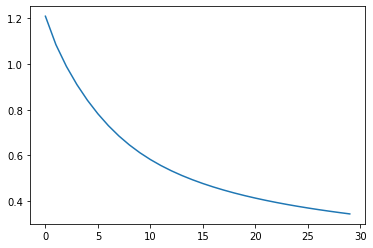

In [196]:
print('Training on Washington DC')
train_dataset = ArgoverseDataset(city='washington-dc', split='train')
val_dataset = ArgoverseDataset(city='washington-dc', split='val')
X_train_nn1 = train_dataset.nn1_inputs
y_train_nn1 = train_dataset.nn1_outputs
X_val_nn1 = val_dataset.nn1_inputs
y_val_nn1 = val_dataset.nn1_outputs
loss1 = nn1.train_model(
    X_train_nn1, 
    y_train_nn1, 
    X_val_nn1,
    y_val_nn1,
    n_epochs = 30, 
    target_len = 1, 
    batch_size = 32, 
    patience = 8,
    threshold = 1e-6,
    training_prediction = 'recursive', 
    learning_rate = 1e-6
)
plt.plot(loss1)

Training on Palo Alto
Epoch 0 train loss, validation loss, time: 5.29523, 4.20523, 3.65518
Epoch 3 train loss, validation loss, time: 4.47971, 3.65378, 2.82917
Epoch 6 train loss, validation loss, time: 3.95822, 3.22200, 2.64543
Epoch 9 train loss, validation loss, time: 3.56010, 2.84874, 4.42544
Epoch 12 train loss, validation loss, time: 3.21639, 2.54389, 3.01115
Epoch 15 train loss, validation loss, time: 2.89869, 2.30817, 2.93870
Epoch 18 train loss, validation loss, time: 2.57394, 2.12097, 3.53919
Epoch 21 train loss, validation loss, time: 2.25637, 1.96492, 3.37176
Epoch 24 train loss, validation loss, time: 2.04087, 1.84369, 5.10487
Epoch 27 train loss, validation loss, time: 1.86599, 1.75995, 3.43042


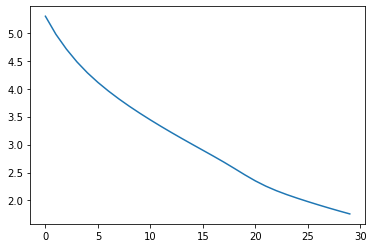

In [197]:
print('Training on Palo Alto')
train_dataset = ArgoverseDataset(city='palo-alto', split='train')
val_dataset = ArgoverseDataset(city='palo-alto', split='val')
X_train_nn1 = train_dataset.nn1_inputs
y_train_nn1 = train_dataset.nn1_outputs
X_val_nn1 = val_dataset.nn1_inputs
y_val_nn1 = val_dataset.nn1_outputs
loss1 = nn1.train_model(
    X_train_nn1, 
    y_train_nn1, 
    X_val_nn1,
    y_val_nn1,
    n_epochs = 30, 
    target_len = 1, 
    batch_size = 32, 
    patience = 8,
    threshold = 1e-6,
    training_prediction = 'recursive', 
    learning_rate = 1e-6
)
plt.plot(loss1)

## Train NN2

In [71]:
# 10 epochs over each city instead?
nn2 = lstm_encoder_decoder2.lstm_seq2seq(
    input_size = 2, 
    input_len = 49,
    hidden_size = 64,
    output_size = 2,
    num_layers = 1,
    dropout = 0.3
)

In [78]:
nn2.train()
print('Training on Austin')
train_dataset = ArgoverseDataset(city='austin', split='train')
val_dataset = ArgoverseDataset(city='austin', split='val')
X_train_nn2 = train_dataset.nn2_inputs
y_train_nn2 = train_dataset.nn2_outputs
X_val_nn2 = val_dataset.nn2_inputs
y_val_nn2 = val_dataset.nn2_outputs
loss2 = nn2.train_model(
    X_train_nn2, 
    y_train_nn2, 
    X_val_nn2,
    y_val_nn2,
    n_epochs = 20, 
    target_len = 59, 
    batch_size = 32, 
    patience = 3,
    threshold = 1e-1,
    training_prediction = 'mixed_teacher_forcing', 
    teacher_forcing_ratio = 0.6, 
    learning_rate = 0.0001,
    dynamic_tf = True
)
plt.plot(loss2)

Training on Austin
Epoch 0 train loss, validation loss, time: 0.01866, 0.06793, 99.56687
Epoch 2 train loss, validation loss, time: 0.00418, 0.29134, 80.34905
Epoch 4 train loss, validation loss, time: 0.00339, 0.07368, 81.37248
Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.
Epoch 6 train loss, validation loss, time: 0.00275, 0.06412, 82.58676
Epoch 8 train loss, validation loss, time: 0.00291, 0.05104, 80.52936


KeyboardInterrupt: 

In [164]:
nn2.train()
print('Training on Miami')
train_dataset = ArgoverseDataset(city='miami', split='train')
X_train_nn2 = train_dataset.nn2_inputs
y_train_nn2 = train_dataset.nn2_outputs
loss2 = nn2.train_model(
    X_train_nn2, 
    y_train_nn2, 
    n_epochs = 20, 
    target_len = 59, 
    batch_size = 32, 
    patience = 3,
    threshold = 1e-1,
    training_prediction = 'mixed_teacher_forcing', 
    teacher_forcing_ratio = 0.6, 
    learning_rate = 0.0001, 
    dynamic_tf = True
)
plt.plot(loss2)

Epoch 0 loss, time: 0.00716, 57.02797
Epoch 2 loss, time: 0.00673, 53.98833
Epoch 4 loss, time: 0.00672, 59.37870
Epoch 6 loss, time: 0.00671, 47.98922
Epoch 8 loss, time: 0.00690, 51.71577


KeyboardInterrupt: 

In [165]:
nn2.train()
print('Training on Pittsburgh')
train_dataset = ArgoverseDataset(city='pittsburgh', split='train')
X_train_nn2 = train_dataset.nn2_inputs
y_train_nn2 = train_dataset.nn2_outputs
loss2 = nn2.train_model(
    X_train_nn2, 
    y_train_nn2, 
    n_epochs = 20, 
    target_len = 59, 
    batch_size = 32, 
    patience = 3,
    threshold = 1e-1,
    training_prediction = 'mixed_teacher_forcing', 
    teacher_forcing_ratio = 0.6, 
    learning_rate = 0.0001, 
    dynamic_tf = True
)
plt.plot(loss2)

Epoch 0 loss, time: 0.00632, 43.25292
Epoch 2 loss, time: 0.00585, 47.53550
Epoch 4 loss, time: 0.00593, 35.54933


KeyboardInterrupt: 

In [ ]:
nn2.train()
print('Training on Dearborn')
train_dataset = ArgoverseDataset(city='dearborn', split='train')
X_train_nn2 = train_dataset.nn2_inputs
y_train_nn2 = train_dataset.nn2_outputs
loss2 = nn2.train_model(
    X_train_nn2, 
    y_train_nn2, 
    n_epochs = 20, 
    target_len = 59, 
    batch_size = 32, 
    patience = 3,
    threshold = 1e-1,
    training_prediction = 'mixed_teacher_forcing', 
    teacher_forcing_ratio = 0.6, 
    learning_rate = 0.0001, 
    dynamic_tf = True
)
plt.plot(loss2)

In [ ]:
nn2.train()
print('Training on Washington DC')
train_dataset = ArgoverseDataset(city='washington-dc', split='train')
X_train_nn2 = train_dataset.nn2_inputs
y_train_nn2 = train_dataset.nn2_outputs
loss2 = nn2.train_model(
    X_train_nn2, 
    y_train_nn2, 
    n_epochs = 20, 
    target_len = 59, 
    batch_size = 32, 
    patience = 3,
    threshold = 1e-1,
    training_prediction = 'mixed_teacher_forcing', 
    teacher_forcing_ratio = 0.6, 
    learning_rate = 0.0001, 
    dynamic_tf = True
)
plt.plot(loss2)

In [ ]:
nn2.train()
print('Training on Palo Alto')
train_dataset = ArgoverseDataset(city='palo-alto', split='train')
X_train_nn2 = train_dataset.nn2_inputs
y_train_nn2 = train_dataset.nn2_outputs
loss2 = nn2.train_model(
    X_train_nn2, 
    y_train_nn2, 
    n_epochs = 20, 
    target_len = 59, 
    batch_size = 32, 
    patience = 3,
    threshold = 1e-1,
    training_prediction = 'mixed_teacher_forcing', 
    teacher_forcing_ratio = 0.6, 
    learning_rate = 0.0001, 
    dynamic_tf = True
)
plt.plot(loss2)

In [198]:
val_dataset = ArgoverseDataset('austin', 'val')

In [199]:
%%time
nn1.eval()
nn2.eval()
print_every = 20
loss = nn.MSELoss()

total_loss = 0
c = 0
for n in range(val_dataset.__len__()):
    nn1_nth_input, _, nn2_nth_input, _, _, _, _, nth_output_centered = val_dataset.__getitem__(n)
    init_pos = nn1.predict(nn1_nth_input, 1)
    deltas = nn2.predict(nn2_nth_input, 59)
    prediction = torch.cumsum(torch.cat((init_pos, deltas)), dim=0)
    cur_loss = loss(prediction, nth_output_centered).item()
    if n % int(val_dataset.__len__() / print_every) == 0: 
        print(str(100 * c / print_every) + '% completed: ' + str(cur_loss))
        c += 1
    total_loss += cur_loss
    
total_loss / val_dataset.__len__()

0.0% completed: 1.7466447353363037
5.0% completed: 105.30644989013672
10.0% completed: 40.35795593261719
15.0% completed: 76.4268798828125
20.0% completed: 270.22198486328125
25.0% completed: 116.44819641113281
30.0% completed: 3.638361930847168
35.0% completed: 33.84343338012695
40.0% completed: 56.04792404174805
45.0% completed: 62.8679084777832
50.0% completed: 37.358421325683594
55.0% completed: 84.37673950195312
60.0% completed: 14.306848526000977
65.0% completed: 12.016301155090332
70.0% completed: 237.53466796875
75.0% completed: 0.41785576939582825
80.0% completed: 150.93820190429688
85.0% completed: 3.679729461669922
90.0% completed: 40.955623626708984
95.0% completed: 69.24708557128906
100.0% completed: 2.943922996520996


44.051480861620206

## Train on all cities

In [13]:
nn1 = lstm_encoder_decoder2.lstm_seq2seq(
    input_size = 2, 
    hidden_size = 15,
    num_layers = 2,
    dropout = 0.3
)

nn2 = lstm_encoder_decoder2.lstm_seq2seq(
    input_size = 2, 
    hidden_size = 25,
    num_layers = 2,
    dropout = 0.3
)

nn1.train()
nn2.train()

# device = "gpu:0"
# input = input.to(device)
# model = model.to(device)

for city in cities:
    print('Training ' + str(city))
    train_dataset = ArgoverseDataset(city=city, split='train')
    X_train_nn1 = train_dataset.nn1_inputs
    y_train_nn1 = train_dataset.nn1_outputs
    X_train_nn2 = train_dataset.nn2_inputs
    y_train_nn2 = train_dataset.nn2_outputs
    X_train = train_dataset.input_positions
    y_train = train_dataset.output_positions
    loss2 = nn2.train_model(
        X_train_nn2, 
        y_train_nn2, 
        n_epochs = 200,
        target_len = 59,
        batch_size = 100, 
        training_prediction = 'mixed_teacher_forcing', 
        teacher_forcing_ratio = 0.6, 
        learning_rate = 0.0001, 
        dynamic_tf = False
    )
    loss1 = nn1.train_model(
        X_train_nn1, 
        y_train_nn1, 
        n_epochs = 200,
        target_len = 1, 
        batch_size = 100, 
        training_prediction = 'mixed_teacher_forcing', 
        teacher_forcing_ratio = 0.6, 
        learning_rate = 0.001, 
        dynamic_tf = False
    )

Training austin
test


  0%|                                                                                                  | 0/200 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [203]:
%%time
nn1.eval()
nn2.eval()

all_preds = []
for city in cities:
    test_dataset = ArgoverseDataset(city=city, split='test')
    rows = []
    c = 0
    for n in range(test_dataset.__len__()):
        if n % int(test_dataset.__len__() / print_every) == 0 and n > 0: 
            c += 1
            print(str(100 * c / print_every) + '% completed for ' + str(city))
        nn1_nth_input, nn2_nth_input, center_input = test_dataset.__getitem__(n)
        init_pos = torch.Tensor(nn1.predict(nn1_nth_input, 1))
        deltas = torch.Tensor(nn2.predict(nn2_nth_input, 59))
        pred = (torch.cumsum(torch.cat((init_pos, deltas)), dim=0).flatten() + center_input).numpy()
        rows.append(pred)
    ids = np.array([str(i) + '_' + city for i in range(len(rows))])
    cols = np.array(['v' + str(i) for i in range(120)])
    predictions = pd.DataFrame(rows, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
all_predictions = pd.concat(all_preds, ignore_index=True)

5.0% completed for austin
10.0% completed for austin
15.0% completed for austin
20.0% completed for austin
25.0% completed for austin
30.0% completed for austin
35.0% completed for austin
40.0% completed for austin
45.0% completed for austin
50.0% completed for austin
55.0% completed for austin
60.0% completed for austin
65.0% completed for austin
70.0% completed for austin
75.0% completed for austin
80.0% completed for austin
85.0% completed for austin
90.0% completed for austin
95.0% completed for austin
100.0% completed for austin
5.0% completed for miami
10.0% completed for miami
15.0% completed for miami
20.0% completed for miami
25.0% completed for miami
30.0% completed for miami
35.0% completed for miami
40.0% completed for miami
45.0% completed for miami
50.0% completed for miami
55.0% completed for miami
60.0% completed for miami
65.0% completed for miami
70.0% completed for miami
75.0% completed for miami
80.0% completed for miami
85.0% completed for miami
90.0% completed for

Save and load model weights: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [205]:
torch.save(nn1, 'nn1_weights.pth')
torch.save(nn2, 'nn2_weights.pth')

In [204]:
all_predictions.to_csv('two_lstm_enc_dec_out.csv', index=False)